# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part C 

## Implement Custom Resnet + Layer Normalization

In [3]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([out_channels, size, size])
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([out_channels, size, size])

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x += shortcut
        x = self.elu(x)
        return x

class CustomResNet_LN(nn.Module):
    def __init__(self):
        super(CustomResNet_LN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([32, 32, 32])
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([64, 32, 32])
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64, 16)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.ln3 = nn.LayerNorm([128, 16, 16])
        self.elu3 = nn.ELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.ln4 = nn.LayerNorm([256, 8, 8])
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256, 4)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.ln5 = nn.LayerNorm(256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.ln3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.ln4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.ln5(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## Load Dataset

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [6]:
# Model, optimizer, and scheduler
model = CustomResNet_LN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet_LN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln1): LayerNorm((32, 32, 32), eps=1e-05, elementwise_affine=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln2): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ln1): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ln2): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
  )
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln3): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  (elu3): ELU(alpha=1.0)
  (maxpool2): Ma

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [9]:
for epoch in range(1, 101):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 2.1351, Train Accuracy: 32.42%, Val Loss: 2.0535, Val Accuracy: 40.42%
Epoch: 2, Train Loss: 2.0061, Train Accuracy: 45.93%, Val Loss: 1.9830, Val Accuracy: 48.78%
Epoch: 3, Train Loss: 1.9429, Train Accuracy: 52.48%, Val Loss: 1.9273, Val Accuracy: 54.14%
Epoch: 4, Train Loss: 1.8892, Train Accuracy: 57.91%, Val Loss: 1.9091, Val Accuracy: 55.28%
Epoch: 5, Train Loss: 1.8546, Train Accuracy: 61.21%, Val Loss: 1.8197, Val Accuracy: 64.90%
Epoch: 6, Train Loss: 1.8185, Train Accuracy: 65.03%, Val Loss: 1.8550, Val Accuracy: 61.22%
Epoch: 7, Train Loss: 1.8065, Train Accuracy: 66.08%, Val Loss: 1.8081, Val Accuracy: 65.46%
Epoch: 8, Train Loss: 1.7778, Train Accuracy: 68.92%, Val Loss: 1.7751, Val Accuracy: 68.92%
Epoch: 9, Train Loss: 1.7716, Train Accuracy: 69.47%, Val Loss: 1.7752, Val Accuracy: 68.70%
Epoch: 10, Train Loss: 1.7548, Train Accuracy: 71.11%, Val Loss: 1.7550, Val Accuracy: 71.00%
Epoch: 11, Train Loss: 1.7495, Train Accuracy: 71.62%, Val Loss: 1.76

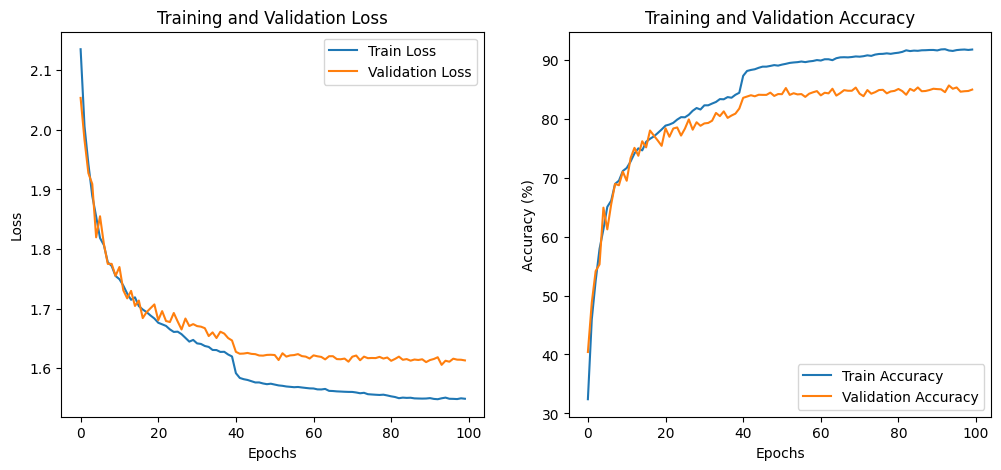

Best Validation Accuracy: 85.62%
Test Accuracy of the final model: 85.24%


In [10]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_LN.pth')

# Layer Wise analyse , Part A

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1tDtBl-yh6DY5hOmfFRFaf1nWqMZP89LD"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [3]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [4]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([out_channels, size, size])
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([out_channels, size, size])

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x += shortcut
        x = self.elu(x)
        return x

class CustomResNet_LN(nn.Module):
    def __init__(self):
        super(CustomResNet_LN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([32, 32, 32])
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([64, 32, 32])
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64, 16)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.ln3 = nn.LayerNorm([128, 16, 16])
        self.elu3 = nn.ELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.ln4 = nn.LayerNorm([256, 8, 8])
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256, 4)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.ln5 = nn.LayerNorm(256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ln1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.ln2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.ln3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.ln4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.ln5(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [5]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.2 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Instantiate and load the model
model = CustomResNet_LN()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_LN.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet_LN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln1): LayerNorm((32, 32, 32), eps=1e-05, elementwise_affine=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln2): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ln1): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ln2): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
  )
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln3): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  (elu3): ELU(alpha=1.0)
  (maxpool2): Ma

In [8]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'softmax', 'ln5', 'flatten', 'fc1', 'fc2'}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [17]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 76.18it/s]


### Calc SI

In [18]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 376.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7337.83it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7389.54it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7353.27it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6903.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7152.63it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7546.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7279.25it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7386.94it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7221.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8385.25it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7116.23it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7018.58it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 5890.88it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7799.00it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7063.50it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6964.97it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7221.60it/s]


In [19]:
si_layer_train

[('conv1', 0.22966666519641876),
 ('ln1', 0.2921111285686493),
 ('elu1', 0.2832222282886505),
 ('conv2', 0.25066667795181274),
 ('ln2', 0.3377777934074402),
 ('elu2', 0.34788888692855835),
 ('maxpool1', 0.45055556297302246),
 ('resblock1', 0.5419999957084656),
 ('conv3', 0.5633333325386047),
 ('ln3', 0.5913333296775818),
 ('elu3', 0.5886666774749756),
 ('maxpool2', 0.61644446849823),
 ('conv4', 0.6521111130714417),
 ('maxpool3', 0.6774444580078125),
 ('ln4', 0.651888906955719),
 ('elu4', 0.6523333191871643),
 ('resblock2', 0.7521111369132996),
 ('avgpool', 0.8098888993263245)]

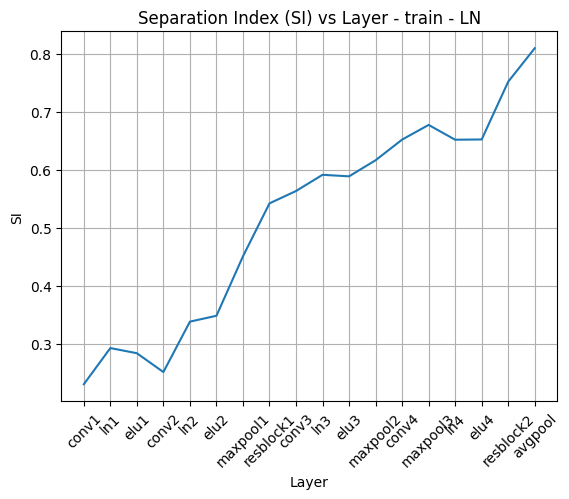

In [20]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - train - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [21]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 882.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4214.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4253.86it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3856.48it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4336.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4487.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3034.51it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3262.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4350.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4399.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4445.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4063.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3212.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3885.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3141.33it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3252.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4186.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2456.54it/s]


[('conv1', 0.34011110663414), ('ln1', 0.3507777750492096), ('elu1', 0.35588890314102173), ('conv2', 0.3668888807296753), ('ln2', 0.3704444468021393), ('elu2', 0.3854444622993469), ('maxpool1', 0.43533334136009216), ('resblock1', 0.5483333468437195), ('conv3', 0.5741111040115356), ('ln3', 0.5745555758476257), ('elu3', 0.5816666483879089), ('maxpool2', 0.597444474697113), ('conv4', 0.6226666569709778), ('maxpool3', 0.6575555801391602), ('ln4', 0.6236666440963745), ('elu4', 0.6322222352027893), ('resblock2', 0.7696666717529297), ('avgpool', 0.8460000157356262)]


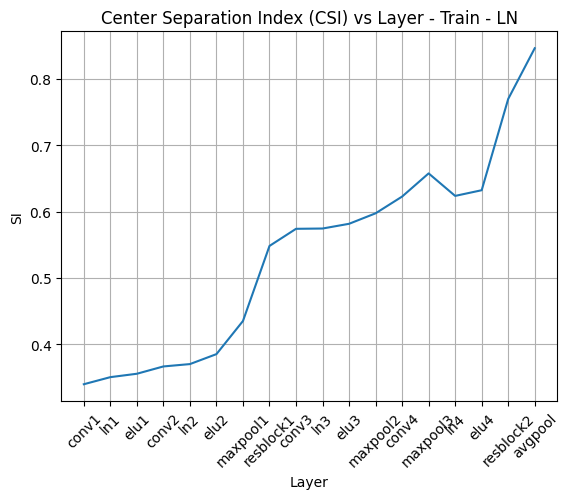

In [22]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Train - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


### Calc SI

In [10]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 217.70it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5104.63it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4741.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4599.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5485.14it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5169.64it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5437.73it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5548.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5356.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4746.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5293.61it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5242.88it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5356.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5023.12it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5940.94it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5602.37it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5309.25it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5137.98it/s]


In [11]:
si_layer_val

[('conv1', 0.20600000023841858),
 ('ln1', 0.2863999903202057),
 ('elu1', 0.2773999869823456),
 ('conv2', 0.2425999939441681),
 ('ln2', 0.3188000023365021),
 ('elu2', 0.33059999346733093),
 ('maxpool1', 0.4339999854564667),
 ('resblock1', 0.5266000032424927),
 ('conv3', 0.5501999855041504),
 ('ln3', 0.5767999887466431),
 ('elu3', 0.5722000002861023),
 ('maxpool2', 0.604200005531311),
 ('conv4', 0.6299999952316284),
 ('maxpool3', 0.6553999781608582),
 ('ln4', 0.6341999769210815),
 ('elu4', 0.6373999714851379),
 ('resblock2', 0.73499995470047),
 ('avgpool', 0.7999999523162842)]

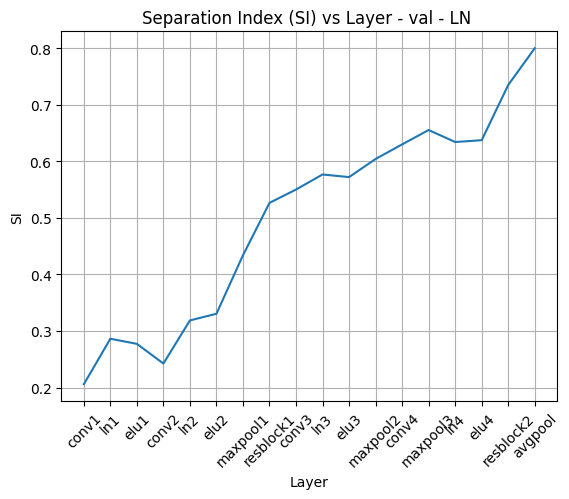

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - val - LN ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [13]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 451.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3302.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3139.45it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3121.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3374.34it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3444.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2923.54it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2985.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3200.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3114.58it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3046.71it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3378.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3095.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3243.85it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3256.45it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3393.45it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3417.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1236.16it/s]


[('conv1', 0.34919998049736023), ('ln1', 0.35679998993873596), ('elu1', 0.36319997906684875), ('conv2', 0.3885999917984009), ('ln2', 0.39259999990463257), ('elu2', 0.407399982213974), ('maxpool1', 0.4675999879837036), ('resblock1', 0.56659996509552), ('conv3', 0.5853999853134155), ('ln3', 0.5841999650001526), ('elu3', 0.5956000089645386), ('maxpool2', 0.6110000014305115), ('conv4', 0.628600001335144), ('maxpool3', 0.6631999611854553), ('ln4', 0.6319999694824219), ('elu4', 0.6383999586105347), ('resblock2', 0.7735999822616577), ('avgpool', 0.8459999561309814)]


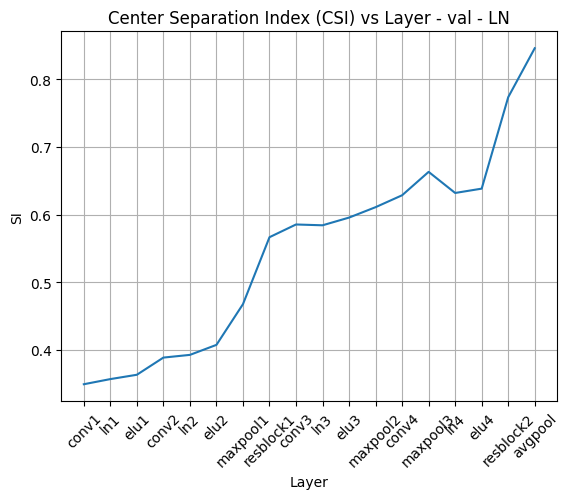

In [14]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - val - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 26.71it/s]


### Calc SI

In [10]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 358.51it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7259.09it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7371.36it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8013.57it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7330.14it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7345.54it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7892.93it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8153.78it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8090.86it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7804.81it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8289.14it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8137.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7701.62it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7216.63it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7172.20it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7319.90it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6749.77it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6743.25it/s]


In [11]:
si_layer_test

[('conv1', 0.23099999129772186),
 ('ln1', 0.299699991941452),
 ('elu1', 0.29350000619888306),
 ('conv2', 0.2685000002384186),
 ('ln2', 0.36739999055862427),
 ('elu2', 0.36579999327659607),
 ('maxpool1', 0.4578000009059906),
 ('resblock1', 0.554099977016449),
 ('conv3', 0.5766000151634216),
 ('ln3', 0.5928999781608582),
 ('elu3', 0.590399980545044),
 ('maxpool2', 0.618399977684021),
 ('conv4', 0.6495999693870544),
 ('maxpool3', 0.6740999817848206),
 ('ln4', 0.6500999927520752),
 ('elu4', 0.6513999700546265),
 ('resblock2', 0.7339999675750732),
 ('avgpool', 0.7622999548912048)]

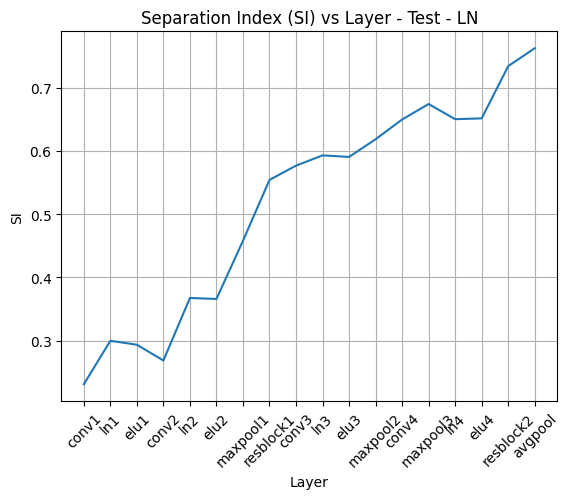

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Test - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [13]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 790.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4374.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4355.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4085.63it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4410.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4264.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3130.08it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3457.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4009.08it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4226.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4227.28it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4286.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3343.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3974.14it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2991.66it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3221.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4472.49it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4714.82it/s]


[('conv1', 0.3447999954223633), ('ln1', 0.3572999835014343), ('elu1', 0.3594000041484833), ('conv2', 0.38169997930526733), ('ln2', 0.3868999779224396), ('elu2', 0.3983999788761139), ('maxpool1', 0.4486999809741974), ('resblock1', 0.5444999933242798), ('conv3', 0.5670999884605408), ('ln3', 0.5669999718666077), ('elu3', 0.5748000144958496), ('maxpool2', 0.5911999940872192), ('conv4', 0.614300012588501), ('maxpool3', 0.6432999968528748), ('ln4', 0.6191999912261963), ('elu4', 0.6251999735832214), ('resblock2', 0.7429999709129333), ('avgpool', 0.7907999753952026)]


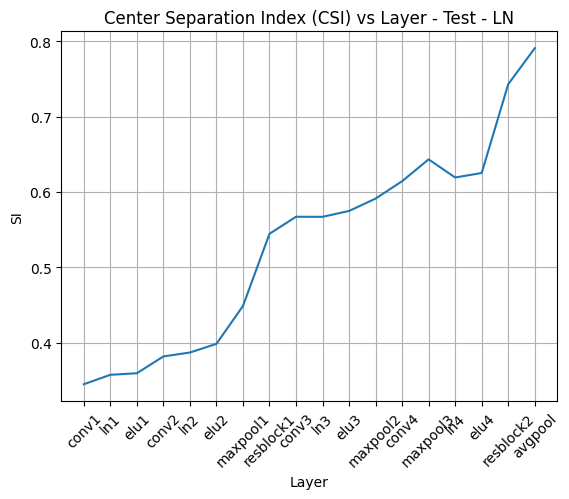

In [14]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Test - LN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()